In [ ]:
import math
import numpy as np
import pandas as pd

import tensorflow as tf
from keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('gdrive/My Drive/Submission_Time_Series/prices-split-adjusted.csv',)

df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [ ]:
df.shape

(851264, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [ ]:
df.isnull().sum()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [ ]:
df = df.loc[(df['symbol'] == 'AAPL')]
df = df.drop(columns=['symbol'])
df = df[['date','open','close','low','volume','high']]
df

,date,open,close,low,volume,high
254,2010-01-04,30.490000,30.572857,30.340000,123432400.0,30.642857
721,2010-01-05,30.657143,30.625713,30.464285,150476200.0,30.798571
1189,2010-01-06,30.625713,30.138571,30.107143,138040000.0,30.747143
1657,2010-01-07,30.250000,30.082857,29.864286,119282800.0,30.285715
2125,2010-01-08,30.042856,30.282858,29.865715,111902700.0,30.285715
...,...,...,...,...,...,...
848767,2016-12-23,115.589996,116.519997,115.589996,14249500.0,116.519997
849267,2016-12-27,116.519997,117.260002,116.489998,18296900.0,117.800003
849767,2016-12-28,117.519997,116.760002,116.199997,20905900.0,118.019997
850267,2016-12-29,116.449997,116.730003,116.400002,15039500.0,117.110001


In [ ]:
df.shape

(1762, 6)

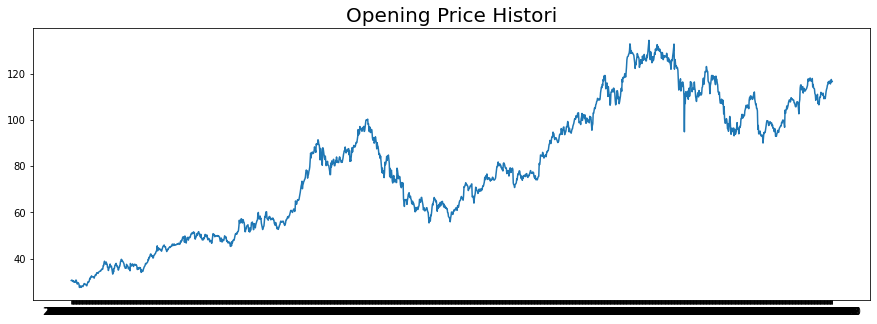

In [ ]:
date = df['date'].values
open  = df['open'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(date, open)
plt.title('Opening Price Histori',
          fontsize=20);

In [ ]:
df = df.filter(['open'])
dataset = df.values

#Mencari tahu jumlah baris yang ada dalam kumpulan data ini untuk melatih model kita.
training_data_len = math.ceil(len(dataset)* .8)
training_data_len

1410

In [ ]:
#mengukur data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.02812312],
       [0.02968552],
       [0.02939173],
       ...,
       [0.84165045],
       [0.83164845],
       [0.83351803]])

In [159]:
#Buat Data Training untuk model
train_data = scaled_data[0:training_data_len , :]
x_train = []
y_train = []

for j in range(60, len(train_data)):
    x_train.append(train_data[j-60:j,0])
    y_train.append(train_data[j,0])
    if j<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.02812312, 0.02968552, 0.02939173, 0.02587968, 0.02394337,
       0.02728183, 0.0224611 , 0.02069841, 0.02368966, 0.02478467,
       0.02131268, 0.0300995 , 0.02632035, 0.01924285, 0.01354077,
       0.01813448, 0.01933631, 0.01677239, 0.01163117, 0.        ,
       0.00472725, 0.00373906, 0.00582227, 0.00034721, 0.00443348,
       0.00540829, 0.00470054, 0.00335181, 0.00766508, 0.0127796 ,
       0.01578421, 0.01236562, 0.01267277, 0.01331375, 0.01018896,
       0.00782533, 0.00669027, 0.01336716, 0.01786739, 0.02344929,
       0.02212727, 0.02258129, 0.03013956, 0.03690993, 0.03463979,
       0.04201108, 0.04211791, 0.04673835, 0.04408093, 0.04247847,
       0.04343993, 0.04237164, 0.04329306, 0.0375242 , 0.04442814,
       0.04709889, 0.05147893, 0.04884823, 0.05425652, 0.05906389])]
[0.05758163718479242]



In [160]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [161]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1350, 60, 1)

In [171]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [173]:
train_set = windowed_dataset(open, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [174]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [176]:
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
43/43 [==============================] - 2s 52ms/step - loss: 0.0212 - mae: 0.1689
Epoch 2/100
43/43 [==============================] - 2s 52ms/step - loss: 0.0211 - mae: 0.1683
Epoch 3/100
43/43 [==============================] - 2s 53ms/step - loss: 0.0209 - mae: 0.1679
Epoch 4/100
43/43 [==============================] - 2s 53ms/step - loss: 0.0208 - mae: 0.1673
Epoch 5/100
43/43 [==============================] - 2s 53ms/step - loss: 0.0207 - mae: 0.1668
Epoch 6/100
43/43 [==============================] - 2s 53ms/step - loss: 0.0205 - mae: 0.1662
Epoch 7/100
43/43 [==============================] - 2s 52ms/step - loss: 0.0204 - mae: 0.1656
Epoch 8/100
43/43 [==============================] - 2s 52ms/step - loss: 0.0202 - mae: 0.1651
Epoch 9/100
43/43 [==============================] - 2s 52ms/step - loss: 0.0201 - mae: 0.1645
Epoch 10/100
43/43 [==============================] - 2s 52ms/step - loss: 0.0200 - mae: 0.1639
Epoch 11/100
43/43 [=============================

In [177]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]

for j in range(60, len(test_data)):
    x_test.append(test_data[j-60:j, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [178]:
predict = model.predict(x_test)
predict = scaler.inverse_transform(predict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


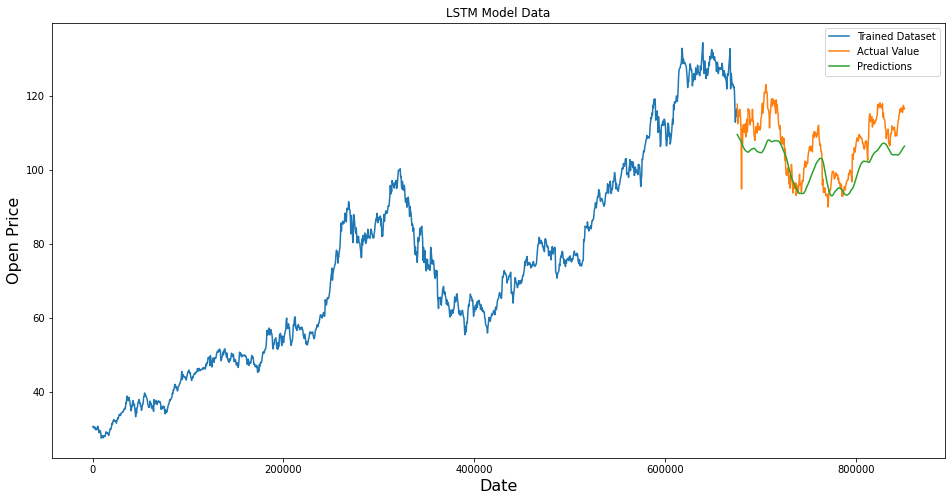

In [179]:
train = df[:training_data_len]
val = df[training_data_len:]
val['Predictions'] = predict

plt.figure(figsize=(16,8))
plt.title('LSTM Model Data')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Open Price', fontsize=16)
plt.plot(train['open'])
plt.plot(val[['open', 'Predictions']])
plt.legend(['Trained Dataset', 'Actual Value', 'Predictions'])
plt.show()

In [180]:
val

,open,Predictions
675609,117.809998,109.593704
676106,112.529999,109.354576
676603,116.040001,109.064011
677100,114.320000,108.822525
677597,116.040001,108.584824
...,...,...
848767,115.589996,105.739922
849267,116.519997,105.927246
849767,117.519997,106.107544
850267,116.449997,106.295738


In [181]:
val.describe()

,open,Predictions
count,352.000000,352.000000
mean,107.135540,101.682182
std,7.994013,5.016899
min,90.000000,92.994164
25%,99.019997,96.473236
50%,108.820000,103.154499
75%,113.655001,105.671936
max,123.129997,109.593704


In [182]:
x = val.open.mean()
y = val.Predictions.mean()
Accuracy = x/y*100
print("The accuracy of the model is " , Accuracy)

The accuracy of the model is  105.36313961228916
